In [266]:
import pandas as pd
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import csv
import seaborn as sns
from datetime import datetime, date
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols

# READ IN DATA
These are cotton growth data and weather data (both PRISM and gridMET). All of these were previously obtained and stored in .csv files.

In [267]:
## Read in Cotton location metadata
# This is from a .csv file that I generated -- based on the tab "location_data" in Maturity_2018_2019.xlsx
# Added a row: LA_2019 (loc_9) because there is a LA_2019 data tab/row in the the spreadsheet. Assuming that
#              the location information for LA_2019 is identical to that of LA_2018 (loc_8)

# Metadata
meta_pd = pd.read_csv(open('CottonDataFiles/stations.csv', 
                             'rb'), 
                        dtype={'Year': float, 'State': str, 
                               'City': str, 'Latitude': float, 
                               'Longitude': float, 'State2':str,'loc_year':str,'loc_id':str})  


In [268]:
# Actual Cotton Growth Stage Data
growth_pd = pd.read_excel(open('CottonDataFiles/Maturity_2018_2019.xlsx', 
                               'rb'), sheet_name='combined_18_19',
                          header=0, usecols = "A,B,D,E,F,G,H,I,J",
                          dtype={'location': str, 'year':int, 'plot': int, 
                                 'cultivar': str, 'loc_year':str, 'loc_var': str, 
                                 'growth stage': str, 'date': str,
                                 'plant_date':str})
growth_pd.dropna(inplace=True)

In [269]:
# Updating (fixing?) Cultivar DP 1851 B2XF to DP 1851 B3XF
growth_pd.loc[growth_pd['cultivar']=='DP 1851 B2XF','cultivar'] = 'DP 1851 B3XF'

### Get Number of Days Between Each Growth Stage

In [270]:
loc_id_arr = meta_pd['loc_id'].tolist()

# Add loc_id column, matching from meta_pd dataframe, to growth_pd dataframe
growth_pd['loc_id'] = ''
for i in range(len(loc_id_arr)):
    loc_yr_id = meta_pd[meta_pd['loc_id'] == loc_id_arr[i]]['loc_year'].values[0]
    growth_pd.loc[(growth_pd['loc_year']==loc_yr_id) ,'loc_id'] = loc_id_arr[i]

growth_pd['date'] = pd.to_datetime(growth_pd['date'], errors='coerce')
growth_pd['plant'] = pd.to_datetime(growth_pd['plant'], errors='coerce')

# Sort everything
growth_pd.sort_values(by=['loc_id','plot','date'],inplace=True)

# Compute the number of elapsed days from plant date to a given growth stage
growth_pd['elapse_days'] = (growth_pd['date']-growth_pd['plant']).dt.days

# Compute the day of year for given growth stage (to make it easier to grab from weather dataframe)
growth_pd['jan1'] = pd.to_datetime(growth_pd['year'].astype(str)+'-1-1')
growth_pd['day_of_year_stage'] = (growth_pd['date'] - growth_pd['jan1']).dt.days
growth_pd.drop(columns='jan1',inplace=True)

In [271]:
# Create a numeric column for stages = called stage num
stage_dict = {'emerge':1,'square':2,'flower':3,'cutout':4,'cracked':5,'60open':6}
growth_pd['stage_num'] = growth_pd['growth stage'].map(stage_dict)

In [272]:
growth_pd.set_index(['loc_id','cultivar','plot'],inplace=True)
growth_pd.sort_index(inplace=True)

In [273]:
# Compute difference (just number of days to get from previous stage to current stage)
growth_pd['diff_days'] = growth_pd['elapse_days']
growth_pd['days_this_stage'] = pd.DataFrame(growth_pd['diff_days'].diff()).reset_index().diff_days.values

# All values for 'emerge' will be NaN, so update with the correct val = elapsed days from plant date to emergence
growth_pd.reset_index(inplace=True)
growth_pd.loc[growth_pd['growth stage']=='emerge','days_this_stage'] = growth_pd['elapse_days']

# Drop the temporary column 'diff_days'
growth_pd.drop(columns=['diff_days'],inplace=True)

# Read in Weather Data

In [274]:
# READ IN THE GRIDMET DATA THAT WE'VE ALREADY OBTAINED
gridmet_in = pd.read_csv('MetDataFiles/GridMET_forAnalysis_2018_2019.csv')
df_gridmet = gridmet_in.pivot(index=['loc_id','latitude','longitude','year','date'],
                    columns=['VarName'])
df_gridmet.reset_index(inplace=True)

In [275]:
# Convert Tmax and Tmin from Kelvin to Fahrenheit (precip is is scaled to units mm)
# These come from NetCDF files
scale_factor = 0.1
offset_min = 210.0
offset_max = 220.0

df_gridmet['tmmn_C'] = ((df_gridmet['Value']['tmmn'] * scale_factor + offset_min))- 273.15
df_gridmet['tmmx_C'] = ((df_gridmet['Value']['tmmx'] * scale_factor + offset_max))- 273.15
df_gridmet['tmmn_F'] = df_gridmet['tmmn_C'] * (9/5) + 32
df_gridmet['tmmx_F'] = df_gridmet['tmmx_C'] * (9/5) + 32
df_gridmet['tmean_F'] = (df_gridmet['tmmx_F'] + df_gridmet['tmmn_F'])/2

df_gridmet['pr_scaled'] = df_gridmet['Value']['pr'] * scale_factor

# Organize column headings (is currently a multiindex, flattening this)
df_gridmet.columns = [''.join(col) for col in df_gridmet.columns.values]

# Drop the unscaled, raw data from the dataframe(but retain the values in deg C, deg F, and mm)
df_gridmet.drop(columns=['Valuepr','Valuesrad','Valuetmmn','Valuetmmx'],inplace=True)

In [276]:
# PRISM data were obtained separately using PRISM's data explorer 
# This is a GUI interfrace where users can enter in a lat/long onto a web interface and download time series
# Since there were only 13 locations for this, and since there's not THREDDS server that provides PRISM from
# https://prism.oregonstate.edu/, this was the fastest route
prism_frames = []
for i in range(len(meta_pd.loc_id.unique().tolist())):
    curr_df = pd.read_csv("MetDataFiles/PRISM_2018_2019/PRISM_"+meta_pd.loc_id.unique().tolist()[i]+".csv",
                          skiprows=10)
    curr_df['loc_id'] = meta_pd.loc_id.unique().tolist()[i]
    prism_frames.append(curr_df)
df_prism = pd.concat(prism_frames)
df_prism.rename(columns={'ppt (inches)':'pr','tmax (degrees F)':'tmmx_F','tmin (degrees F)':'tmmn_F',
                        'tmean (degrees F)':'tmean_F','Date':'Full_date'},inplace=True)
df_prism['date'] = df_prism['Full_date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d').timetuple().tm_yday-1)
df_prism['year'] = df_prism['Full_date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d').timetuple().tm_year)


## Set which temperature dataset to use
(currently using PRISM)

In [277]:
#wxdf = df_gridmet.copy() # gridMET
wxdf = df_prism.copy() # PRISM

# Compute Daily GDD60s and Plot Average Numbers of Days and DDs to Reach Maturity

Text(0.5, 0, 'Growth Stage')

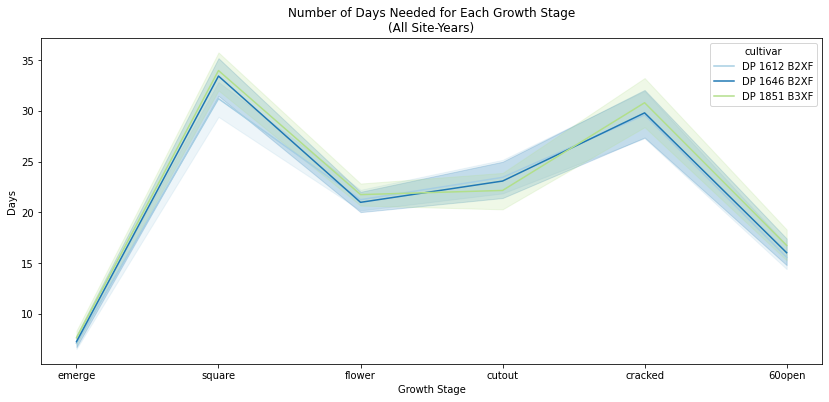

In [278]:
fig,ax = plt.subplots(1,figsize=(14,6))
sns.lineplot(x='growth stage',y='days_this_stage',hue='cultivar',
              data=growth_pd)
ax.set_title("Number of Days Needed for Each Growth Stage\n(All Site-Years)")
ax.set_ylabel('Days')
ax.set_xlabel('Growth Stage')

In [279]:
# Compute Daily GDDs
tbase = 60
wxdf['gdd_default'] = ((wxdf['tmmx_F'] + wxdf['tmmn_F'])/2) - tbase

# Basedon upper/lower thresholds
mask_base = (wxdf['gdd_default'] < 0)

wxdf['gdd_default'] = wxdf['gdd_default'].mask(mask_base, 0)

In [280]:
# There are some duplicate entries for certain stages -- drop these, keeping the first:
growth_pd.drop_duplicates(subset=['loc_id','cultivar','plot','growth stage'],keep='first',inplace=True)

In [281]:
growth_pd.set_index(['loc_id','cultivar','plot'],inplace=True)

In [282]:
# Add two columns to store total cumulative gdd needed for whole season (gdd_cum_needed) and 
# total gdd needed for just give stage from previous stage (gdd_stage_needed)
growth_pd['gdd_cum_needed'] = np.nan
growth_pd['gdd_stage_needed'] = np.nan

# Also add two columns for mean temperature to reach given growth stage from plant date and from previous stage
growth_pd['tmean_seas_to_date'] = np.nan
growth_pd['tmean_stage_only'] = np.nan

for i in set(growth_pd.index):
    
    # Create a local copy of the growth_pd
    copy_growth = growth_pd.loc[i].copy()
    # Get start and end dates corresponding to this location's (loc_id-cultivar-plot) plant date and harvest (60open)
    plant_day = copy_growth[copy_growth['growth stage']=='emerge']['day_of_year_stage'].values[0] - \
                copy_growth[copy_growth['growth stage']=='emerge']['elapse_days'].values[0]
    last_day = copy_growth.day_of_year_stage.max()
    
    # Get weather data corresponding to just this location-plot 
    gdd_df = wxdf[(wxdf['loc_id']==list(i)[0]) & 
                                  (wxdf['date']>=plant_day) &
                                  (wxdf['date']<=last_day)].copy()
    # Compute cumulative gdd sum for given location-plot
    gdd_df['cum_gdd'] = gdd_df['gdd_default'].cumsum()
    
    # Get the cumulative gdd correspnding to each growth stage
    days_stages = copy_growth['day_of_year_stage'].values    
    cum_gdd_stages = gdd_df[gdd_df['date'].isin(days_stages)]['cum_gdd'].values
    
    # Now get number gdd for each stage (not cumulative for whole season):
    gdd_each_stage = pd.DataFrame(cum_gdd_stages).diff()
    gdd_each_stage[0].iloc[0] = cum_gdd_stages[0]
    gdd_each_stage = gdd_each_stage.values
    
    # Get the mean temperature corresponding to each growth stage from plant date
    tmean_stage = []
    tmean_each_stage = []
    for d in range(len(days_stages)):
        tmean_stage.append(gdd_df[(gdd_df['date']>=plant_day) & (gdd_df['date']<=days_stages[d])]['tmean_F'].mean())
        
        # If on emergence date:
        if(d==0):
            tmean_each_stage.append(tmean_stage[d])
        else:
            tmean_each_stage.append(gdd_df[
                (gdd_df['date']>=days_stages[d-1]) & (gdd_df['date']<=days_stages[d])]['tmean_F'].mean())
    
    
    # DO WE ACTUALLY HAVE INFO FOR EACH GROWTH STAGE? IF NOT, THEN GET RID OF ROWS CORRESPONDING TO THE MISSING STAGE
    all_poss_stages = [x for x in range(1,7)]
    if len(copy_growth['stage_num'].unique())<6:
        # Get the missing stage
        miss_stages = np.setdiff1d(all_poss_stages,copy_growth['stage_num'].unique())
        
        # Need to set both the stage after the missing stage, as well as missing stage, to np.nan
        # For tmean. 
        for m in range(len(miss_stages)):
            miss_indx = miss_stages[0]-1
            miss_end = min(miss_indx+1,len(miss_stages)-1)
                        
            tmean_stage[miss_indx] = np.nan
            tmean_each_stage[miss_indx] = np.nan    
            cum_gdd_stages[miss_indx] = np.nan
            gdd_each_stage[miss_indx] = np.nan
            
            tmean_stage[miss_end] = np.nan
            tmean_each_stage[miss_end] = np.nan    
            cum_gdd_stages[miss_end] = np.nan
            gdd_each_stage[miss_end] = np.nan
    
    
    # Now add total accumulated gdd from plant date to get to each stage, and total for each stage, to growth_pd
    growth_pd.loc[i,'gdd_cum_needed'] = cum_gdd_stages
    growth_pd.loc[i,'gdd_stage_needed'] = gdd_each_stage
    
    # Now add mean temperatures to growth_pd
    growth_pd.loc[i,'tmean_seas_to_date'] = tmean_stage
    growth_pd.loc[i,'tmean_stage_only'] = tmean_each_stage

In [283]:
growth_pd.reset_index(inplace=True)

# Group sites into a training set (2018) and a test/validation set (2019) 

In [284]:
# First, add in a running accumulationof Tmean and of cumulative GDD, as well as the YTD means of each (i.e., the
# YTD running average Tmean, cumulative GDD)
wxdf['cum_gdd'] = list(wxdf.groupby(['loc_id'])['gdd_default'].cumsum())
wxdf['cum_tmean'] = list(wxdf.groupby(['loc_id'])['tmean_F'].cumsum())

wxdf['cum_gdd_running_mean'] = wxdf['cum_gdd'] / (wxdf['date']+1)
wxdf['cum_tmean_running_mean'] = wxdf['cum_tmean'] / (wxdf['date']+1)

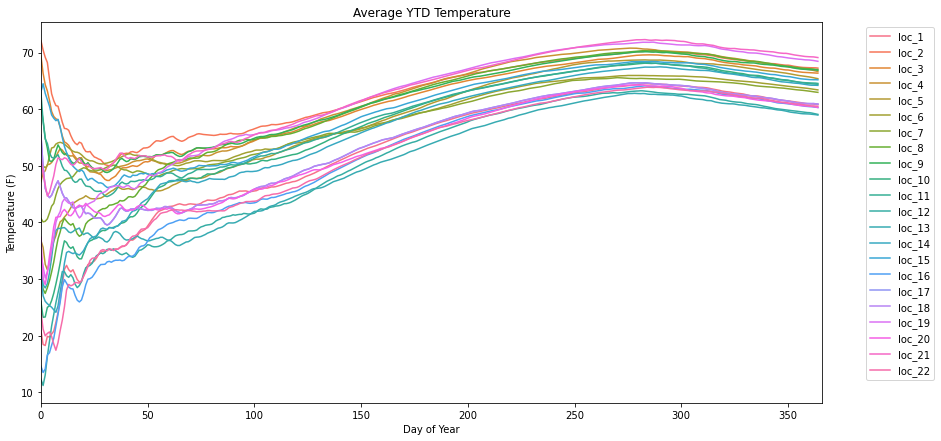

In [285]:
fig,ax=plt.subplots(1,figsize=(14,7))
sns.lineplot(data=wxdf,x='date',y='cum_tmean_running_mean',hue='loc_id')
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_title("Average YTD Temperature")
ax.set_ylabel("Temperature (F)")
ax.set_xlabel("Day of Year")
ax.set_xlim(0,366);

In [286]:
print("Pearson Correlation between all YTD average temperatures")
pd.DataFrame(wxdf[['loc_id','cum_tmean_running_mean']].pivot(columns='loc_id')).corr()

Pearson Correlation between all YTD average temperatures


cum_tmean_running_mean                      \
loc_id                                         loc_1    loc_10    loc_11   
                       loc_id                                              
cum_tmean_running_mean loc_1                1.000000  0.999392  0.904712   
                       loc_10               0.999392  1.000000  0.904498   
                       loc_11               0.904712  0.904498  1.000000   
                       loc_12               0.992028  0.991021  0.920889   
                       loc_13               0.950472  0.947984  0.972316   
                       loc_14               0.998330  0.996962  0.907950   
                       loc_15               0.845819  0.846522  0.990293   
                       loc_16               0.999192  0.999113  0.909966   
                       loc_17               0.913540  0.912540  0.997759   
                       loc_18               0.913540  0.912540  0.997759   
                       loc_19               0.996169  0.997081  0.919686   
                       loc_2                0.821375  0.822470  0.982459   
                       loc_20               0.961342  0.958339  0.959438   
                       loc_21               0.963624  0.961833  0.977213   
                       loc_22               0.997061  0.994754  0.908450   
                       loc_3                0.851083  0.852045  0.991640   
                       loc_4                0.947680  0.947137  0.983141   
                       loc_5                0.985231  0.982767  0.944125   
                       loc_6                0.908081  0.904512  0.977579   
                       loc_7                0.971424  0.967964  0.947404   
                       loc_8                0.997941  0.999446  0.899997   
                       loc_9                0.933660  0.932717  0.996458   

                                                                       \
loc_id                           loc_12    loc_13    loc_14    loc_15   
                       loc_id                                           
cum_tmean_running_mean loc_1   0.992028  0.950472  0.998330  0.845819   
                       loc_10  0.991021  0.947984  0.996962  0.846522   
                       loc_11  0.920889  0.972316  0.907950  0.990293   
                       loc_12  1.000000  0.973407  0.986713  0.870825   
                       loc_13  0.973407  1.000000  0.947112  0.943774   
                       loc_14  0.986713  0.947112  1.000000  0.848189   
                       loc_15  0.870825  0.943774  0.848189  1.000000   
                       loc_16  0.995460  0.956481  0.996024  0.854228   
                       loc_17  0.933982  0.983854  0.915067  0.984968   
                       loc_18  0.933982  0.983854  0.915067  0.984968   
                       loc_19  0.995534  0.963225  0.991883  0.866592   
                       loc_2   0.838558  0.916632  0.827202  0.994341   
                       loc_20  0.981647  0.997386  0.958094  0.923441   
                       loc_21  0.978048  0.996659  0.962527  0.945186   
                       loc_22  0.987848  0.950344  0.999203  0.849146   
                       loc_3   0.868337  0.938403  0.855569  0.997059   
                       loc_4   0.968168  0.994149  0.944946  0.961578   
                       loc_5   0.993399  0.985762  0.983856  0.897241   
                       loc_6   0.938299  0.988877  0.906013  0.964243   
                       loc_7   0.988725  0.992532  0.968263  0.906830   
                       loc_8   0.989252  0.943988  0.994656  0.841506   
                       loc_9   0.947116  0.984604  0.935973  0.977103   

                                                             ...            \
loc_id                           loc_16    loc_17    loc_18  ...    loc_20   
                       loc_id                                ...             
cum_tmean_running_mean loc_1   0.999192  0.913540  0.913540  ...  0.9

In [287]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(loc_id)', data=pd.DataFrame(wxdf[['loc_id','cum_tmean_running_mean']].pivot(columns='loc_id')).melt()).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(loc_id),126114.960262,21.0,70.838581,1.742867e-276
Residual,678893.301050,8008.0,NaN,NaN


---
# Compute the average number of GDD60s needed for each stage, by cultivar, using the training set (2018 data)

In [288]:
# Already have the data, just need to average for our training set (2018)
avg_gdds_all_stages_2018 = growth_pd[growth_pd['year']==2018].groupby(
    ['cultivar','growth stage']).mean().reset_index()\
    .sort_values(by=['cultivar','stage_num'])

display(growth_pd[growth_pd['year']==2018].groupby(
    ['cultivar','stage_num'])[['gdd_cum_needed','gdd_stage_needed']].describe().round(2))

gdd_cum_needed                                     \
                                count     mean     std      min      25%   
cultivar     stage_num                                                     
DP 1612 B2XF 1                   32.0   101.50   54.70    46.15    67.16   
             2                   40.0   626.12  101.24   372.95   599.78   
             3                   40.0  1103.69  139.20   746.00  1052.12   
             4                   32.0  1634.44  243.38  1336.60  1492.37   
             5                   32.0  2178.53  230.73  1704.50  2063.20   
             6                   40.0  2484.24  263.33  2095.85  2219.25   
DP 1646 B2XF 1                   32.0    94.92   52.05    46.15    66.30   
             2                   40.0   647.60  114.96   387.30   595.49   
             3                   40.0  1118.56  128.22   762.55  1069.49   
             4                   32.0  1672.81  251.70  1336.60  1524.35   
             5                   32.0  2221.35  228.05  1742.55  2098.29   
             6                   40.0  2542.30  249.06  2164.85  2300.31   
DP 1851 B3XF 1                   32.0   111.76   63.02    46.15    67.16   
             2                   40.0   680.82  133.67   387.30   618.25   
             3                   40.0  1175.32  155.82   762.55  1139.40   
             4                   32.0  1689.93  267.69  1336.60  1519.90   
             5                   32.0  2256.21  234.09  1834.50  2131.19   
             6                   40.0  2582.32  244.56  2195.60  2356.00   

                                                  gdd_stage_needed          \
                            50%      75%      max            count    mean   
cultivar     stage_num                                                       
DP 1612 B2XF 1            84.00   111.74   281.15             32.0  101.50   
             2           618.80   682.00   875.80             40.0  524.42   
             3          1094.05  1183.50  1308.85             40.0  477.56   
             4          1559.30  1701.59  2143.10             32.0  537.94   
             5          2167.40  2334.94  2539.50             32.0  544.08   
             6          2507.55  2746.15  2876.40             40.0  303.40   
DP 1646 B2XF 1            75.40   111.74   226.70             32.0   94.92   
             2           642.53   693.72   851.50             40.0  551.99   
             3          1131.68  1190.44  1324.15             40.0  470.96   
             4          1585.50  1783.65  2237.15             32.0  555.54   
             5          2167.90  2445.79  2580.00             32.0  548.54   
             6          2549.48  2740.35  2997.75             40.0  324.23   
DP 1851 B3XF 1            86.08   174.31   262.35             32.0  111.76   
             2           678.23   729.94   916.50             40.0  569.54   
             3          1186.25  1257.20  1466.25             40.0  494.49   
             4          1599.87  1845.71  2285.75             32.0  514.08   
             5          2198.30  2454.70  2625.30             32.0  566.27   
             6          2577.28  2749.89  3017.70             40.0  333.46   

                                                                         
                           std     min     25%     50%     75%      max  
cultivar     stage_num                                                   
DP 1612 B2XF 1           54.70   46.15   67.16   84.00  111.74   281.15  
             2           88.36  326.80  490.39  529.50  567.51   726.90  
             3           92.59  332.10  419.40  454.92  506.22   700.70  
             4          227.40  196.40  318.89  533.95  668.56  1049.05  
             5          176.14  183.40  458.01  519.12  701.22   847.45  
             6          133.14   11.95  174.73  329.55  393.38   550.70  
DP 1646 B2XF 1           52.05   46.15   66.30   75.40  111.74   226.70  
             2          110.92  341.15  482.22 

---
# Now compare predictions based on above thresholds using test/validation set (2019 data) 

In [289]:
# Create a copy of growth_pd -- is where we'll compute predicted GDDs/dates for each stage based on 2018 data
growth_pd_test = growth_pd[growth_pd['year']==2019].copy()
growth_pd_test.set_index(['loc_id','cultivar','plot'],inplace=True)

In [290]:
# Add two columns to store predicted day of year at which each stage reached (pred_day_of_year_stage) and the 
# predicted number of days since the previous grwoth stage it took to reach given stage (pred_day_stageonly)
growth_pd_test['pred_day_of_year_stage'] = np.nan
growth_pd_test['pred_day_stageonly'] = np.nan

for i in set(growth_pd_test.index):
    
    # Create a local copy of the growth_pd_test
    copy_growth = growth_pd_test.loc[i].copy()
    
    # Get start date corresponding to this location's (loc_id-cultivar-plot) plant date 
    plant_day = copy_growth[copy_growth['growth stage']=='emerge']['day_of_year_stage'].values[0] - \
                copy_growth[copy_growth['growth stage']=='emerge']['elapse_days'].values[0]
    
    # Get the average cumulative gdd correspnding to each growth stage
    gdds_req_stages_cum = avg_gdds_all_stages_2018[avg_gdds_all_stages_2018['cultivar']==list(i)[1]]\
                                      ['gdd_cum_needed'].values  
    gdds_req_stages_each = avg_gdds_all_stages_2018[avg_gdds_all_stages_2018['cultivar']==list(i)[1]]\
                                      ['gdd_stage_needed'].values  
    # Get the observed number of days to reach each stage
    obs_dayofyear_stage = copy_growth['day_of_year_stage'].values # day of year that stage occurred
    obs_day_this_stage = copy_growth['days_this_stage'].values  # just since previous stage
    
    # Get weather data corresponding to just this location-plot 
    gdd_df = wxdf[(wxdf['loc_id']==list(i)[0]) & (wxdf['date']>=plant_day)].copy()
    
    # Compute cumulative gdd sum for given location-plot
    gdd_df['cum_gdd'] = gdd_df['gdd_default'].cumsum()
    
    # Some site-plots don't have observed data for all growth stages -- get the stage numbers for which we have data
    obs_stages = list(growth_pd_test.loc[i,'stage_num'])
    
    # Predict day of year that growth stage will occur on by comparing gdd_df['cum_gdd'] with gdds_req_stages_cum
    pred_day_ind = [x*np.nan for x in range(len(gdds_req_stages_each))]
    for g in range(len(gdds_req_stages_cum)):
        vals_gt = list(gdd_df[gdd_df['cum_gdd']>=gdds_req_stages_cum[g]]['date'])
        if len(vals_gt)>0:
            pred_day_ind[g] = vals_gt[0]
    
    # Predict n days from previous stage to current one by comparing gdd_df['gdd_default'] with gdds_req_stages_each
    pred_ndays_stage = [x*np.nan for x in range(len(gdds_req_stages_each))]
    gdd_ticker = 0
    for g in range(len(gdds_req_stages_each)):
        
        # print day of year current stage:
        prev_stage_day = plant_day
        if g>0:
            prev_stage_day = obs_dayofyear_stage[g-1]
        
        stage_gdd = wxdf[(wxdf['loc_id']==list(i)[0]) & (wxdf['date']>=prev_stage_day)].copy().reset_index()
        stage_gdd['cum_gdd_stage'] = stage_gdd['gdd_default'].cumsum()
        
        vals_gt = list(stage_gdd[stage_gdd['cum_gdd_stage']>=gdds_req_stages_each[g]].index)
        if len(vals_gt)>0:
            pred_ndays_stage[g] = vals_gt[0]
    
    # DO WE ACTUALLY HAVE INFO FOR EACH GROWTH STAGE? IF NOT, THEN GET RID OF ROWS CORRESPONDING TO THE MISSING STAGE
    all_poss_stages = [x for x in range(1,7)]
    if len(copy_growth['stage_num'].unique())<6:
                
        # Get the missing stage
        miss_stages = np.setdiff1d(all_poss_stages,copy_growth['stage_num'].unique())
        
        # Need to set both the stage after the missing stage, as well as missing stage, to np.nan
        for m in range(len(miss_stages)):
            miss_indx = miss_stages[0]-1
            miss_end = min(miss_indx+1,len(miss_stages)-1)
            
            pred_day_ind[miss_indx] = np.nan
            pred_ndays_stage[miss_indx] = np.nan    
            
            pred_day_ind[miss_end] = np.nan
            pred_ndays_stage[miss_end] = np.nan    
            
    
    # Now get output predicted days based on what we actually have observed data for:
    pred_day_ind_out = [pred_day_ind[obs_stages[x]-1] for x in range(len(obs_stages))]
    pred_ndays_stage_out = [pred_ndays_stage[obs_stages[x]-1] for x in range(len(obs_stages))]  
    
    # Now add total accumulated gdd from plant date to get to each stage, and total for each stage, to growth_pd
    growth_pd_test.loc[i,'pred_day_of_year_stage'] = pred_day_ind_out
    growth_pd_test.loc[i,'pred_day_stageonly'] = pred_ndays_stage_out

In [291]:
growth_pd_test['each_stage_diff'] = growth_pd_test['days_this_stage'] - growth_pd_test['pred_day_stageonly']
growth_pd_test['cum_stage_diff'] = growth_pd_test['day_of_year_stage'] - growth_pd_test['pred_day_of_year_stage']

In [292]:
growth_pd_test.groupby(['cultivar','stage_num'])[['each_stage_diff','cum_stage_diff']].describe()

each_stage_diff                                        \
                                 count      mean        std   min   25%  50%   
cultivar     stage_num                                                         
DP 1612 B2XF 1                    48.0 -1.729167   4.350298 -11.0 -4.00 -0.5   
             2                    48.0 -0.270833   9.380241 -21.0 -3.75  1.0   
             3                    48.0 -3.166667   5.207741 -10.0 -6.25 -4.0   
             4                    48.0 -1.270833   5.637034 -11.0 -5.00 -3.0   
             5                    48.0  3.250000   7.030329  -9.0 -0.25  3.5   
             6                    48.0  1.083333   6.856689 -27.0 -2.25  0.0   
DP 1646 B2XF 1                    48.0 -0.895833   4.576720 -11.0 -3.00  0.0   
             2                    48.0  1.416667  11.073897 -21.0 -4.25  3.5   
             3                    48.0 -2.854167   4.824537 -11.0 -6.00 -3.0   
             4                    48.0 -2.916667   6.424134 -12.0 -9.00 -3.5   
             5                    48.0  2.750000   8.647961 -13.0 -2.00  1.0   
             6                    46.0  0.282609   6.949542  -9.0 -5.00 -1.5   
DP 1851 B3XF 1                    48.0 -1.958333   4.703816 -12.0 -4.00 -1.0   
             2                    48.0  1.000000  10.120550 -20.0 -3.50  4.0   
             3                    48.0 -3.375000   4.408044 -10.0 -6.00 -4.0   
             4                    48.0 -1.125000   6.492631 -10.0 -6.00 -3.0   
             5                    48.0  3.354167   9.665665 -14.0 -2.00  2.0   
             6                    46.0 -1.260870  10.384678 -47.0 -5.75 -3.0   

                                    cum_stage_diff                             \
                          75%   max          count      mean        std   min   
cultivar     stage_num                                                          
DP 1612 B2XF 1           2.00   4.0           48.0 -1.729167   4.350298 -11.0   
             2           5.25  18.0           48.0 -1.354167  11.187930 -25.0   
             3          -1.00  10.0           48.0 -3.895833  10.867166 -31.0   
             4           3.00  10.0           48.0 -5.062500   8.101500 -20.0   
             5           6.50  17.0           48.0 -2.645833  11.917249 -27.0   
             6           5.00  15.0           40.0  0.175000  14.861562 -28.0   
DP 1646 B2XF 1           2.25   7.0           48.0 -0.895833   4.576720 -11.0   
             2          10.25  20.0           48.0  1.187500  12.954349 -25.0   
             3          -1.00   9.0           48.0 -1.166667  11.852522 -30.0   
             4           1.25  13.0           48.0 -4.333333   7.053996 -18.0   
             5           7.00  28.0           48.0 -2.562500  13.390861 -27.0   
             6           5.50  14.0           36.0 -4.833333  20.315371 -44.0   
DP 1851 B3XF 1           1.25   8.0           48.0 -1.958333   4.703816 -12.0   
             2           7.25  18.0           48.0  0.104167  12.123899 -23.0   
             3          -2.00  10.0           48.0 -2.645833  10.855903 -27.0   
             4           2.25  14.0           48.0 -4.458333   7.604473 -21.0   
             5           7.25  27.0           48.0 -2.375000  14.451128 -29.0   
             6           6.75  14.0           32.0 -0.250000  18.277432 -33.0   

                                                 
                          25%  50%    75%   max  
cultivar     stage_num                           
DP 1612 B2XF 1          -4.00 -0.5   2.00   4.0  
             2          -5.25 -0.5   5.25  21.0  
             3          -7.00 -3.0   3.00  11.0  
             4         -12.25 -3.0   1.00   7.0  
             5          -8.25 -2.5   3.50  20.0  
             6         -10.75 -2.5  11.25  25.0  
DP 1646 B2XF 1          -3.00  0.0   2.25   7.0  
             2          -4.00  3.0  11.00  23.0  
             3          -5.00 -1.0   9.00  16.0  
             4          -8.75 -2.0   1.0

### Save GDD60 Output to Excel

In [296]:
with pd.ExcelWriter('OutputFiles/GDD60_ThresholdsPredictions.xlsx') as writer:  
    avg_gdds_all_stages_2018.round(2)
    growth_pd[growth_pd['year']==2018].groupby(['cultivar','stage_num'])\
            [['gdd_cum_needed','gdd_stage_needed']].describe().round(2)\
            .to_excel(writer,sheet_name='GDD60-Thresholds')
    
    growth_pd_test.groupby(['cultivar','stage_num'])[['each_stage_diff','cum_stage_diff']
                                                    ].describe().round(2).to_excel(
        writer,sheet_name='GDD60-Predictions')

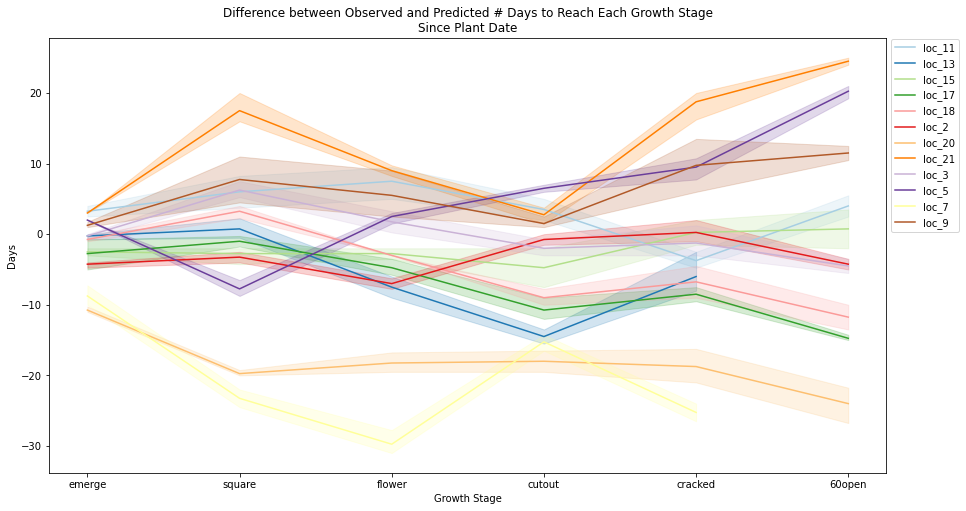

In [294]:
fix, ax = plt.subplots(1,figsize=(15,8))

sns.set_palette("Paired")
g = sns.lineplot(x='growth stage',y='cum_stage_diff',hue='loc_id',
              data=growth_pd_test.reset_index()[growth_pd_test.reset_index()['cultivar']=='DP 1612 B2XF'],ax=ax)
ax.legend(bbox_to_anchor=(1, 1.01))
ax.set_xlabel('Growth Stage')
ax.set_ylabel('Days')
ax.set_title('Difference between Observed and Predicted # Days to Reach Each Growth Stage\nSince Plant Date');

plt.savefig('OutputFiles/GDD60_ObsPredDaysDiff_SincePlant.png')

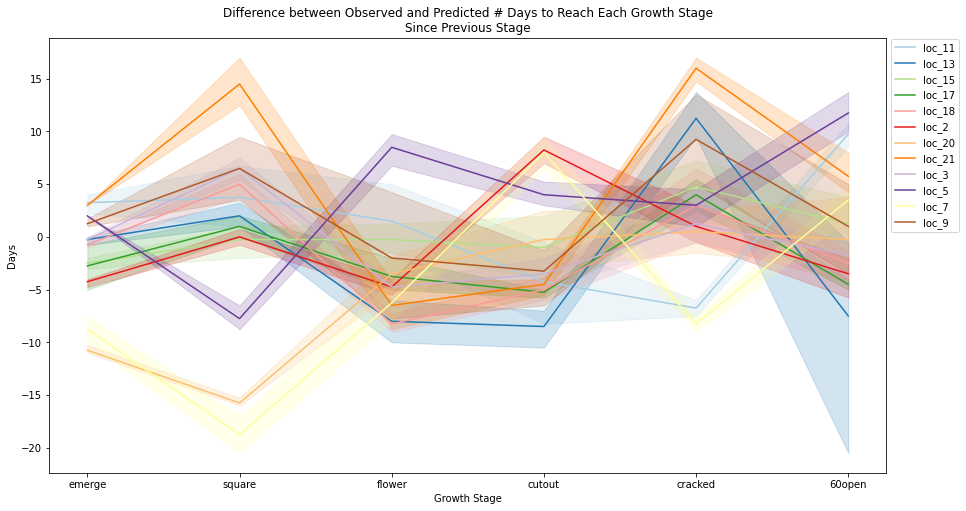

In [295]:
fix, ax = plt.subplots(1,figsize=(15,8))

sns.set_palette("Paired")
g = sns.lineplot(x='growth stage',y='each_stage_diff',hue='loc_id',
              data=growth_pd_test.reset_index()[growth_pd_test.reset_index()['cultivar']=='DP 1612 B2XF'],ax=ax)
ax.legend(bbox_to_anchor=(1, 1.01))
ax.set_xlabel('Growth Stage')
ax.set_ylabel('Days')
ax.set_title('Difference between Observed and Predicted # Days to Reach Each Growth Stage\nSince Previous Stage');

plt.savefig('OutputFiles/GDD60_ObsPredDaysDiff_SincePreviousStage.png')